# Binary ECG Beat Classification

This notebook classifies ECG beats as normal (0) or irregular (1) using a 1D CNN. The data has been preprocessed: beat windows extracted, filtered with 0.5-40 Hz bandpass, and per-beat z-score normalized.


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
import random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize_scalar
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    brier_score_loss,
)
from sklearn.utils import class_weight
from sklearn.calibration import calibration_curve

# Set random seeds for reproducibility (ALL seeds)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
random.seed(SEED)

# Configure plotting
sns.set_theme(style='whitegrid')
plt.rcParams.update({'figure.figsize': (10, 6)})

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")


TensorFlow version: 2.16.2
NumPy version: 1.26.4


In [29]:
# Load preprocessed data
DATA_DIR = Path('.')
X = np.load(DATA_DIR / 'X.npy').astype(np.float32)
y_raw = np.load(DATA_DIR / 'y.npy', allow_pickle=True)

print(f"Loaded X: {X.shape}")
print(f"Loaded y: {y_raw.shape}")
print(f"X dtype: {X.dtype}, y dtype: {y_raw.dtype}")

# Check unique labels in raw data
unique_labels, counts = np.unique(y_raw, return_counts=True)
print(f"\nUnique labels in raw data: {unique_labels}")
print("Label distribution:")
for label, count in zip(unique_labels, counts):
    pct = 100.0 * count / len(y_raw)
    print(f"  '{label}': {count} beats ({pct:.2f}%)")


Loaded X: (112551, 301, 2)
Loaded y: (112551,)
X dtype: float32, y dtype: object

Unique labels in raw data: ['-1' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Label distribution:
  '-1': 8 beats (0.01%)
  '0': 108321 beats (96.24%)
  '1': 2922 beats (2.60%)
  '2': 656 beats (0.58%)
  '3': 222 beats (0.20%)
  '4': 128 beats (0.11%)
  '5': 200 beats (0.18%)
  '6': 24 beats (0.02%)
  '7': 60 beats (0.05%)
  '8': 7 beats (0.01%)
  '9': 3 beats (0.00%)


In [30]:
# Convert labels to binary: 0 for normal beats ('0'), 1 for any irregular beat
# In this dataset, '0' represents normal beats, other values are irregular
NORMAL_LABEL = '0'
binary_labels = np.where(y_raw == NORMAL_LABEL, 0, 1).astype(np.int32)

# Display binary label distribution
unique, counts = np.unique(binary_labels, return_counts=True)
print("Binary label distribution:")
for cls, cnt in zip(unique, counts):
    pct = 100.0 * cnt / len(binary_labels)
    print(f"  Class {cls}: {cnt} beats ({pct:.2f}%)")
    
print(f"\nTotal beats: {len(binary_labels)}")
print(f"Normal beats (0): {np.sum(binary_labels == 0)}")
print(f"Irregular beats (1): {np.sum(binary_labels == 1)}")


Binary label distribution:
  Class 0: 108321 beats (96.24%)
  Class 1: 4230 beats (3.76%)

Total beats: 112551
Normal beats (0): 108321
Irregular beats (1): 4230


In [31]:
# Stratified train/validation/test split (70/15/15)
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    binary_labels,
    test_size=0.30,
    stratify=binary_labels,
    random_state=SEED,
)

# Second split: 50% of temp goes to val, 50% to test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=SEED,
)

# Display split information
print("Data splits:")
for name, X_split, y_split in [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test)
]:
    unique_vals, counts = np.unique(y_split, return_counts=True)
    summary = ', '.join([f'class {v}: {c} ({100.0*c/len(y_split):.2f}%)' 
                        for v, c in zip(unique_vals, counts)])
    print(f"{name:12s} -> {X_split.shape} | {summary}")

print(f"\nTotal samples: {len(X)}")
print(f"Train: {len(X_train)} ({100*len(X_train)/len(X):.1f}%)")
print(f"Validation: {len(X_val)} ({100*len(X_val)/len(X):.1f}%)")
print(f"Test: {len(X_test)} ({100*len(X_test)/len(X):.1f}%)")


Data splits:
Train        -> (78785, 301, 2) | class 0: 75824 (96.24%), class 1: 2961 (3.76%)
Validation   -> (16883, 301, 2) | class 0: 16248 (96.24%), class 1: 635 (3.76%)
Test         -> (16883, 301, 2) | class 0: 16249 (96.24%), class 1: 634 (3.76%)

Total samples: 112551
Train: 78785 (70.0%)
Validation: 16883 (15.0%)
Test: 16883 (15.0%)


Before augmentation:
  Class 0: 75824 samples
  Class 1: 2961 samples

After augmentation:
  Class 0: 75824 samples
  Class 1: 37912 samples
  Total: 113736 samples
  Class 1 percentage: 33.33%


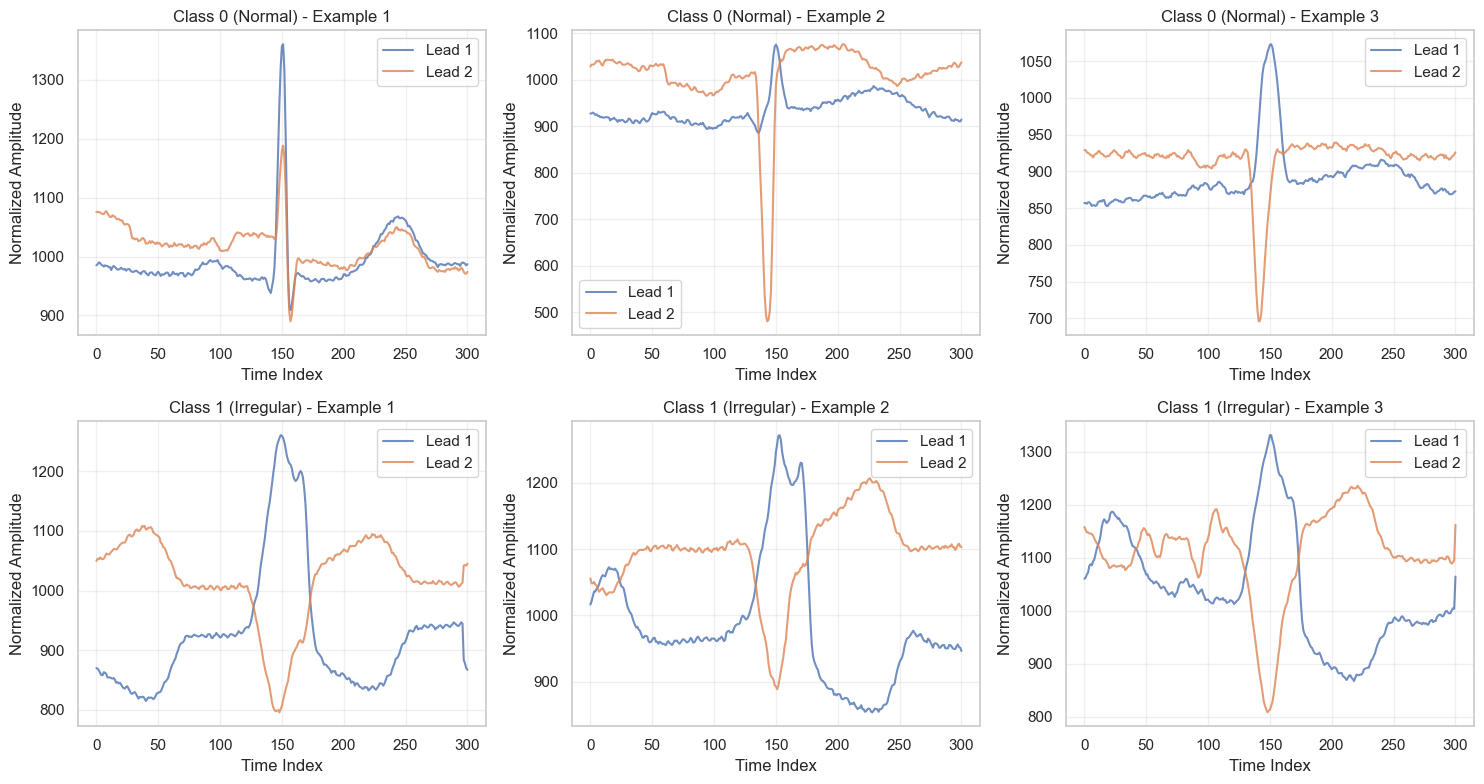

In [32]:
# Data augmentation functions for ECG beats
def augment_ecg_beat(beat, rng, jitter_std=0.02, scale_range=0.05, time_shift_max=5):
    """
    Augment a single ECG beat with noise, scaling, and time shifting.
    
    Args:
        beat: ECG beat array (time_steps, features)
        rng: Random number generator
        jitter_std: Standard deviation for Gaussian noise
        scale_range: Range for random scaling (e.g., 0.05 = ±5%)
        time_shift_max: Maximum time shift in samples
    
    Returns:
        Augmented beat
    """
    augmented = beat.copy()
    
    # Add Gaussian noise
    noise = rng.normal(0.0, jitter_std, size=augmented.shape)
    augmented = augmented + noise
    
    # Random scaling per lead
    scale = 1.0 + rng.uniform(-scale_range, scale_range, size=(1, augmented.shape[-1]))
    augmented = augmented * scale
    
    # Time shifting (circular shift)
    if time_shift_max > 0:
        shift = rng.integers(-time_shift_max, time_shift_max + 1)
        if shift != 0:
            augmented = np.roll(augmented, shift, axis=0)
    
    return augmented

def augment_minority_class(X, y, target_class=1, multiplier=3.0, rng=None):
    """
    Augment minority class samples to balance the dataset.
    
    Args:
        X: Feature array
        y: Labels
        target_class: Class to augment (minority class)
        multiplier: How many times to replicate minority samples
        rng: Random number generator
    
    Returns:
        Augmented X and y
    """
    if rng is None:
        rng = np.random.default_rng(SEED)
    
    minority_indices = np.where(y == target_class)[0]
    if len(minority_indices) == 0:
        return X, y
    
    # Calculate how many samples to generate
    n_minority = len(minority_indices)
    n_majority = len(y) - n_minority
    target_minority = int(n_majority * 0.5)  # Target 50% of majority class size
    n_to_generate = max(0, target_minority - n_minority)
    
    # Generate augmented samples
    augmented_samples = []
    augmented_labels = []
    
    for _ in range(n_to_generate):
        # Randomly select a minority sample to augment
        idx = rng.choice(minority_indices)
        augmented_beat = augment_ecg_beat(X[idx], rng)
        augmented_samples.append(augmented_beat)
        augmented_labels.append(target_class)
    
    if len(augmented_samples) > 0:
        X_aug = np.concatenate([X, np.array(augmented_samples)], axis=0)
        y_aug = np.concatenate([y, np.array(augmented_labels)], axis=0)
        
        # Shuffle
        perm = rng.permutation(len(X_aug))
        return X_aug[perm], y_aug[perm]
    
    return X, y

# Apply augmentation to training set
print("Before augmentation:")
print(f"  Class 0: {np.sum(y_train == 0)} samples")
print(f"  Class 1: {np.sum(y_train == 1)} samples")

rng = np.random.default_rng(SEED)
X_train_aug, y_train_aug = augment_minority_class(X_train, y_train, target_class=1, multiplier=3.0, rng=rng)

print("\nAfter augmentation:")
print(f"  Class 0: {np.sum(y_train_aug == 0)} samples")
print(f"  Class 1: {np.sum(y_train_aug == 1)} samples")
print(f"  Total: {len(y_train_aug)} samples")
print(f"  Class 1 percentage: {100*np.sum(y_train_aug == 1)/len(y_train_aug):.2f}%")

# Update training data
X_train = X_train_aug
y_train = y_train_aug

# Visualize sample beats from each class
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

examples_per_class = 3
for class_idx in [0, 1]:
    class_mask = y_train == class_idx
    if np.sum(class_mask) == 0:
        print(f"Warning: No examples found for class {class_idx}")
        continue
    
    class_indices = np.where(class_mask)[0]
    selected_indices = rng.choice(class_indices, 
                                 size=min(examples_per_class, len(class_indices)), 
                                 replace=False)
    
    for i, idx in enumerate(selected_indices):
        ax = axes[class_idx * examples_per_class + i]
        sample = X_train[idx]
        ax.plot(sample[:, 0], label='Lead 1', alpha=0.8)
        ax.plot(sample[:, 1], label='Lead 2', alpha=0.8)
        ax.set_title(f'Class {class_idx} ({["Normal", "Irregular"][class_idx]}) - Example {i+1}')
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Normalized Amplitude')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [33]:
# Build improved 1D CNN model with better regularization for imbalanced data
def build_1d_cnn(input_shape):
    """
    Build a 1D CNN model for ECG beat classification with improved regularization.
    
    Args:
        input_shape: Shape of input (time_steps, features)
    
    Returns:
        Compiled Keras model
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # First convolutional block with regularization
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=7, padding='same', 
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Second convolutional block
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Third convolutional block
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding='same',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Dense layers with stronger regularization
    x = tf.keras.layers.Dense(128, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Output layer (binary classification)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Focal loss for imbalanced binary classification
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss to address class imbalance by focusing on hard examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Weighting factor for positive class
    """
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Calculate p_t
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        # Calculate alpha_t
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Calculate focal weight
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
        
        # Calculate focal loss
        focal_loss = focal_weight * cross_entropy
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fn

# Create model
input_shape = X_train.shape[1:]
model = build_1d_cnn(input_shape)

# Compile model with focal loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=focal_loss(gamma=2.0, alpha=0.25),  # Use focal loss for imbalanced data
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),  # Precision-Recall AUC
    ]
)

# Display model architecture
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 301, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 301, 64)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 301, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 301, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 301, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 150, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             

 Total params: 184,385 (720.25 KB)

 Trainable params: 183,105 (715.25 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [34]:
# Compute class weights for balanced training (after augmentation)
class_weights_dict = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_dict)}
print("Class weights for balanced training (after augmentation):")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.4f}")

# Note: With focal loss, class weights are less critical but still helpful


Class weights for balanced training (after augmentation):
  Class 0: 0.7500
  Class 1: 1.5000


Validation set class balance:
  Positives (irregular): 635
  Negatives (normal): 16248
  ✓ Validation set has sufficient positive samples for stable threshold tuning
Starting training with focal loss and data augmentation...
Monitoring validation PR-AUC for early stopping (no per-epoch threshold tuning)...
Epoch 1/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9529 - auc: 0.9907 - loss: 0.0172 - pr_auc: 0.9837 - precision: 0.9728 - recall: 0.8845
Epoch 1: val_pr_auc improved from None to 0.75320, saving model to checkpoints/best_model.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 393s 874ms/step - accuracy: 0.9549 - auc: 0.9914 - loss: 0.0164 - pr_auc: 0.9849 - precision: 0.9742 - recall: 0.8883 - val_accuracy: 0.9811 - val_auc: 0.9490 - val_loss: 0.0256 - val_pr_auc: 0.7532 - val_precision: 0.7992 - val_recall: 0.6646 - learning_rate: 2.5000e-04
Epoch 2/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9582 - auc: 0.9923 - loss: 0.0153 - pr_auc: 0.9866 - precision: 0.9769 

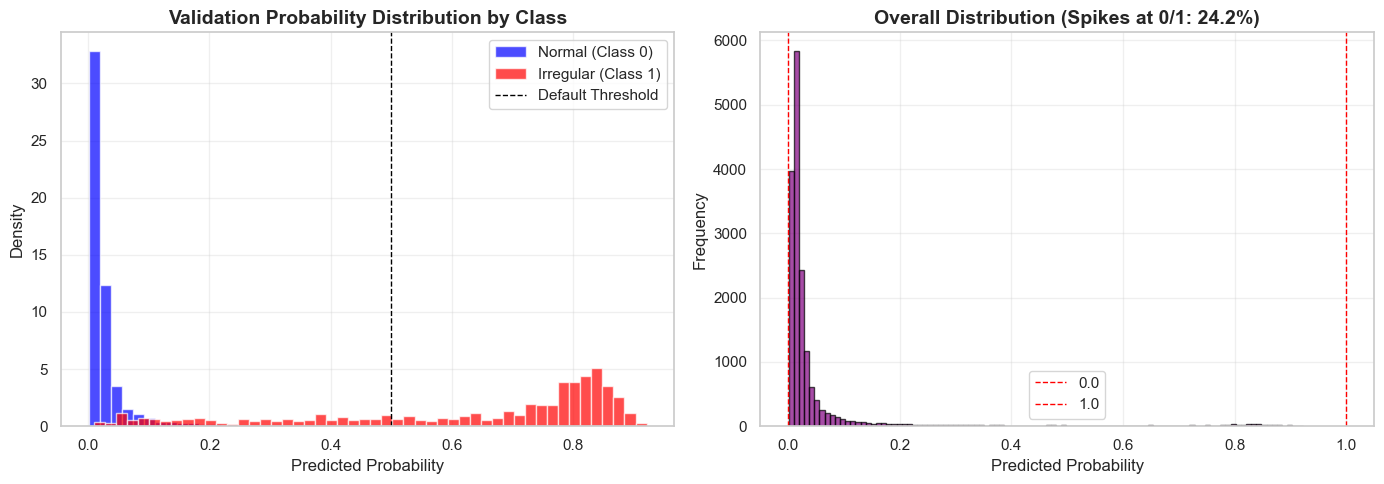

  ⚠ WARNING: 24.2% of predictions are at extremes (0 or 1)
  This indicates overconfidence. Calibration is recommended.

Applying temperature scaling calibration...
  Optimizing temperature parameter on validation set...
  Optimal temperature: 0.5957
  ✓ Saved optimal temperature to checkpoints/optimal_temperature.npy


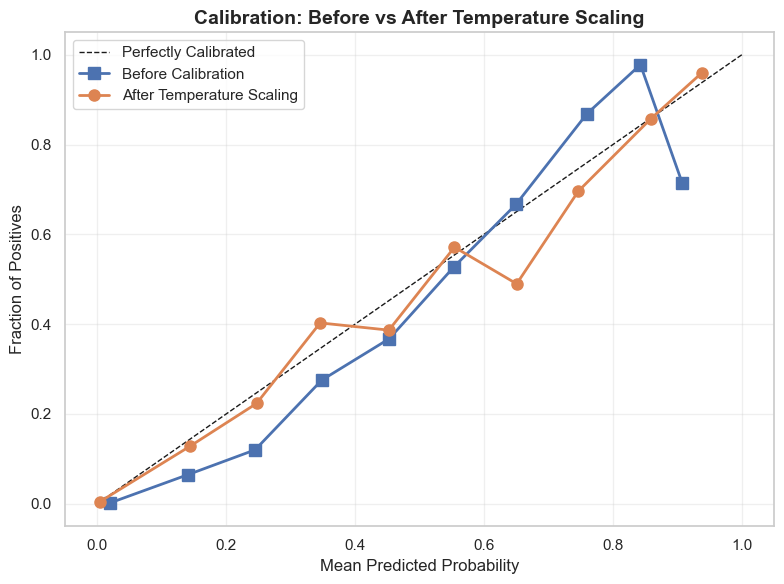


Computing optimal threshold on calibrated validation probabilities...
  Optimal threshold (calibrated): 0.4700 (F1: 0.7784)
  Optimal threshold (uncalibrated): 0.4800 (F1: 0.7781)
  Calibration improved F1 by: +0.0003
  ✓ Saved optimal threshold (calibrated) to checkpoints/best_threshold.npy


In [38]:
# Create checkpoints directory if it doesn't exist
Path('checkpoints').mkdir(exist_ok=True)

# Check validation class balance
val_positives = np.sum(y_val == 1)
val_negatives = np.sum(y_val == 0)
print(f"Validation set class balance:")
print(f"  Positives (irregular): {val_positives}")
print(f"  Negatives (normal): {val_negatives}")
if val_positives < 100:
    print(f"  ⚠ WARNING: Only {val_positives} positive samples in validation set!")
    print(f"  Threshold tuning may be unstable. Consider:")
    print(f"    - Using stratified k-fold CV")
    print(f"    - Increasing validation set size")
    print(f"    - Using PR-AUC instead of F1 for early stopping")
else:
    print(f"  ✓ Validation set has sufficient positive samples for stable threshold tuning")

# Define callbacks - NO per-epoch threshold tuning (too expensive and unstable)
# Monitor PR-AUC instead (better for imbalanced data)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_pr_auc',  # PR-AUC is better for imbalanced data than F1
        mode='max',
        patience=12,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc',
        mode='max',
        factor=0.5,
        patience=6,
        min_lr=1e-6,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='checkpoints/best_model.keras',
        monitor='val_pr_auc',  # Save based on PR-AUC
        mode='max',
        save_best_only=True,
        verbose=1,
    ),
]

# Train the model
BATCH_SIZE = 256
EPOCHS = 30

print("Starting training with focal loss and data augmentation...")
print("Monitoring validation PR-AUC for early stopping (no per-epoch threshold tuning)...")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1,
)

print("\nTraining completed!")

# Post-training: Compute optimal threshold ONCE on full validation set
print("\n" + "=" * 80)
print("POST-TRAINING: Computing optimal threshold on validation set")
print("=" * 80)

# Load best model and set to eval mode
best_model = tf.keras.models.load_model(
    'checkpoints/best_model.keras',
    custom_objects={'focal_loss_fn': focal_loss(gamma=2.0, alpha=0.25)}
)
# Note: In TF 2.x, model.predict() automatically runs in inference mode (dropout/BatchNorm off)
# Setting trainable=False ensures no training updates
best_model.trainable = False

# Get validation predictions in eval mode (dropout/BatchNorm off)
print("Getting validation predictions (eval mode, no dropout/BatchNorm)...")
val_proba_raw = best_model.predict(X_val, batch_size=BATCH_SIZE, verbose=0).flatten()

# Plot probability histograms to check for overconfidence
print("\nPlotting probability histograms to check for overconfidence...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram by class
axes[0].hist(val_proba_raw[y_val == 0], bins=50, alpha=0.7, label='Normal (Class 0)', 
            color='blue', density=True)
axes[0].hist(val_proba_raw[y_val == 1], bins=50, alpha=0.7, label='Irregular (Class 1)', 
            color='red', density=True)
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='Default Threshold')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Validation Probability Distribution by Class', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Check for spikes at 0/1 (overconfidence indicator)
spike_at_0 = np.sum((val_proba_raw < 0.01) | (val_proba_raw > 0.99))
spike_pct = 100.0 * spike_at_0 / len(val_proba_raw)
axes[1].hist(val_proba_raw, bins=100, alpha=0.7, color='purple', edgecolor='black')
axes[1].axvline(x=0.0, color='red', linestyle='--', linewidth=1, label='0.0')
axes[1].axvline(x=1.0, color='red', linestyle='--', linewidth=1, label='1.0')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Overall Distribution (Spikes at 0/1: {spike_pct:.1f}%)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('checkpoints/probability_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

if spike_pct > 10:
    print(f"  ⚠ WARNING: {spike_pct:.1f}% of predictions are at extremes (0 or 1)")
    print("  This indicates overconfidence. Calibration is recommended.")
else:
    print(f"  ✓ Probability distribution looks reasonable ({spike_pct:.1f}% at extremes)")

# Temperature Scaling Calibration
print("\nApplying temperature scaling calibration...")

def temperature_scaled_loss(T, logits, y_true):
    """Loss function for temperature scaling optimization."""
    # Convert probabilities to logits if needed
    if np.all((logits >= 0) & (logits <= 1)):
        # Probabilities - convert to logits
        epsilon = 1e-7
        logits_scaled = np.log(logits + epsilon) - np.log(1 - logits + epsilon)
    else:
        logits_scaled = logits
    
    # Apply temperature
    logits_T = logits_scaled / T
    probs_T = 1.0 / (1.0 + np.exp(-logits_T))
    probs_T = np.clip(probs_T, 1e-7, 1 - 1e-7)
    
    # Negative log likelihood
    nll = -np.mean(y_true * np.log(probs_T) + (1 - y_true) * np.log(1 - probs_T))
    return nll

# Get logits from model (before sigmoid)
# Since model outputs sigmoid, we need to reverse it
epsilon = 1e-7
val_proba_clipped = np.clip(val_proba_raw, epsilon, 1 - epsilon)
val_logits = np.log(val_proba_clipped / (1 - val_proba_clipped))

# Optimize temperature
print("  Optimizing temperature parameter on validation set...")
result = minimize_scalar(
    temperature_scaled_loss,
    args=(val_logits, y_val),
    bounds=(0.1, 10.0),
    method='bounded'
)
optimal_temperature = result.x
print(f"  Optimal temperature: {optimal_temperature:.4f}")

# Apply temperature scaling to validation probabilities
val_logits_scaled = val_logits / optimal_temperature
val_proba_calibrated = 1.0 / (1.0 + np.exp(-val_logits_scaled))
val_proba_calibrated = np.clip(val_proba_calibrated, 0, 1)

# Save temperature
np.save('checkpoints/optimal_temperature.npy', optimal_temperature)
print(f"  ✓ Saved optimal temperature to checkpoints/optimal_temperature.npy")

# Compare calibration before/after
fraction_pos_raw, mean_pred_raw = calibration_curve(y_val, val_proba_raw, n_bins=10, strategy='uniform')
fraction_pos_cal, mean_pred_cal = calibration_curve(y_val, val_proba_calibrated, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=1)
ax.plot(mean_pred_raw, fraction_pos_raw, 's-', label='Before Calibration', linewidth=2, markersize=8)
ax.plot(mean_pred_cal, fraction_pos_cal, 'o-', label='After Temperature Scaling', linewidth=2, markersize=8)
ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration: Before vs After Temperature Scaling', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('checkpoints/calibration_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute optimal threshold on CALIBRATED validation probabilities
print("\nComputing optimal threshold on calibrated validation probabilities...")
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1_cal = 0
optimal_threshold_cal = 0.5
threshold_metrics_cal = []

for thresh in thresholds:
    y_pred_val = (val_proba_calibrated > thresh).astype(int)
    f1 = f1_score(y_val, y_pred_val, zero_division=0)
    precision = precision_score(y_val, y_pred_val, zero_division=0)
    recall = recall_score(y_val, y_pred_val, zero_division=0)
    threshold_metrics_cal.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    if f1 > best_f1_cal:
        best_f1_cal = f1
        optimal_threshold_cal = thresh

print(f"  Optimal threshold (calibrated): {optimal_threshold_cal:.4f} (F1: {best_f1_cal:.4f})")

# Also compute on uncalibrated for comparison
best_f1_raw = 0
optimal_threshold_raw = 0.5
for thresh in thresholds:
    y_pred_val = (val_proba_raw > thresh).astype(int)
    f1 = f1_score(y_val, y_pred_val, zero_division=0)
    if f1 > best_f1_raw:
        best_f1_raw = f1
        optimal_threshold_raw = thresh

print(f"  Optimal threshold (uncalibrated): {optimal_threshold_raw:.4f} (F1: {best_f1_raw:.4f})")
print(f"  Calibration improved F1 by: {best_f1_cal - best_f1_raw:+.4f}")

# Save calibrated threshold
optimal_threshold = optimal_threshold_cal  # Use calibrated threshold
np.save('checkpoints/best_threshold.npy', optimal_threshold)
print(f"  ✓ Saved optimal threshold (calibrated) to checkpoints/best_threshold.npy")


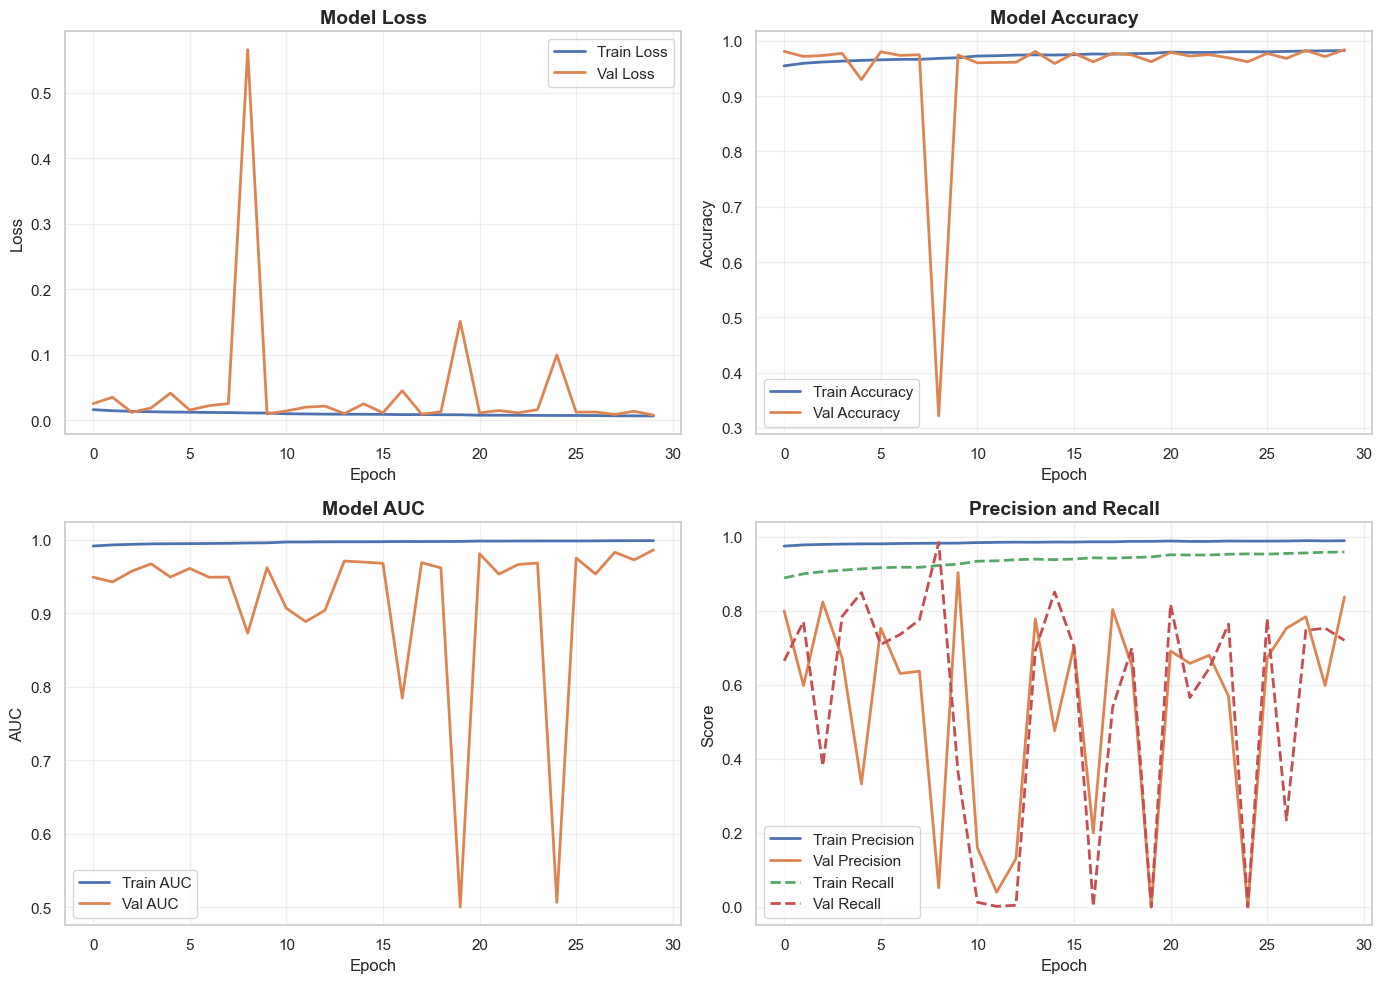

In [39]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Precision and Recall
axes[3].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[3].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[3].plot(history.history['recall'], label='Train Recall', linewidth=2, linestyle='--')
axes[3].plot(history.history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
axes[3].set_title('Precision and Recall', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Score')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:
# ============================================================================
# PRODUCTION-READY EVALUATION PIPELINE
# ============================================================================

print("=" * 80)
print("PRODUCTION EVALUATION PIPELINE")
print("=" * 80)

# 9. Code Hygiene: Clear GPU session before loading
tf.keras.backend.clear_session()
print("\n[1/11] ✓ Cleared Keras session")

# 1. Model Loading: Use EXACT same focal loss instance
print("\n[2/11] Loading model with proper focal loss configuration...")
focal_loss_instance = focal_loss(gamma=2.0, alpha=0.25)
best_model = tf.keras.models.load_model(
    'checkpoints/best_model.keras',
    custom_objects={'focal_loss_fn': focal_loss_instance}
)

# 1. Freeze model after loading
# Note: In TF 2.x, model.predict() automatically runs in inference mode
# Setting trainable=False ensures no training updates
best_model.trainable = False
print("  ✓ Model loaded and frozen for inference (predict() uses inference mode automatically)")

# 3. Validation Split Check
print("\n[3/11] Validating data splits...")
def print_class_distribution(name, y_data):
    unique, counts = np.unique(y_data, return_counts=True)
    dist = {int(u): int(c) for u, c in zip(unique, counts)}
    pct = {int(u): 100.0 * c / len(y_data) for u, c in zip(unique, counts)}
    print(f"  {name}: {dist} ({pct})")
    return dist, pct

train_dist, train_pct = print_class_distribution("Train", y_train)
val_dist, val_pct = print_class_distribution("Validation", y_val)
test_dist, test_pct = print_class_distribution("Test", y_test)

# Check if distributions are similar
val_ratio = val_pct[1] / val_pct[0] if val_pct[0] > 0 else 0
test_ratio = test_pct[1] / test_pct[0] if test_pct[0] > 0 else 0
train_ratio = train_pct[1] / train_pct[0] if train_pct[0] > 0 else 0

print(f"\n  Class imbalance ratios:")
print(f"    Train: {train_ratio:.4f}, Val: {val_ratio:.4f}, Test: {test_ratio:.4f}")
if abs(val_ratio - test_ratio) > 0.01:
    print("  ⚠ Warning: Val and test distributions differ!")
else:
    print("  ✓ Val and test distributions match")

if len(y_val) < len(y_test) * 0.1:
    print(f"  ⚠ Warning: Validation set is <10% of test set ({len(y_val)/len(y_test)*100:.1f}%)")
else:
    print(f"  ✓ Validation set size is adequate ({len(y_val)/len(y_test)*100:.1f}% of test)")

# 2. Output Sanity Check
print("\n[4/11] Performing output sanity checks...")
print("  Getting predictions on validation set (batch prediction only)...")
val_proba = best_model.predict(X_val, batch_size=BATCH_SIZE, verbose=0).flatten()

# Manual sigmoid check (should already be sigmoid, but verify)
print("  Checking output range...")
print(f"    Min probability: {np.min(val_proba):.6f}")
print(f"    Max probability: {np.max(val_proba):.6f}")
print(f"    Mean probability: {np.mean(val_proba):.6f}")

if np.any(val_proba < 0) or np.any(val_proba > 1):
    print("  ⚠ Warning: Probabilities outside [0, 1] range! Applying sigmoid...")
    val_proba = tf.nn.sigmoid(best_model(X_val, training=False)).numpy().flatten()
else:
    print("  ✓ Probabilities are in valid [0, 1] range")

# 4. Threshold Optimization: Coarse → Fine → Micro search
print("\n[5/11] Performing multi-stage threshold optimization on VALIDATION set...")
print("  Stage 1: Coarse search (0.1 to 0.9, step=0.05)...")
thresholds_coarse = np.arange(0.1, 0.9, 0.05)
best_f1_coarse = 0
best_thresh_coarse = 0.5
coarse_results = []

for thresh in thresholds_coarse:
    y_pred_val = (val_proba > thresh).astype(int)
    f1 = f1_score(y_val, y_pred_val, zero_division=0)
    precision = precision_score(y_val, y_pred_val, zero_division=0)
    recall = recall_score(y_val, y_pred_val, zero_division=0)
    coarse_results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    if f1 > best_f1_coarse:
        best_f1_coarse = f1
        best_thresh_coarse = thresh

print(f"    Best coarse threshold: {best_thresh_coarse:.3f} (F1: {best_f1_coarse:.4f})")

# Fine search around best coarse threshold
print("  Stage 2: Fine search (best ± 0.05, step=0.01)...")
fine_range = max(0.01, min(0.49, best_thresh_coarse - 0.05))
fine_range_end = min(0.99, best_thresh_coarse + 0.05)
thresholds_fine = np.arange(fine_range, fine_range_end, 0.01)
best_f1_fine = 0
best_thresh_fine = best_thresh_coarse
fine_results = []

for thresh in thresholds_fine:
    y_pred_val = (val_proba > thresh).astype(int)
    f1 = f1_score(y_val, y_pred_val, zero_division=0)
    precision = precision_score(y_val, y_pred_val, zero_division=0)
    recall = recall_score(y_val, y_pred_val, zero_division=0)
    fine_results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    if f1 > best_f1_fine:
        best_f1_fine = f1
        best_thresh_fine = thresh

print(f"    Best fine threshold: {best_thresh_fine:.3f} (F1: {best_f1_fine:.4f})")

# Micro search
print("  Stage 3: Micro search (best ± 0.01, step=0.001)...")
micro_range = max(0.001, best_thresh_fine - 0.01)
micro_range_end = min(0.999, best_thresh_fine + 0.01)
thresholds_micro = np.arange(micro_range, micro_range_end, 0.001)
best_f1_micro = 0
optimal_threshold = best_thresh_fine
micro_results = []

for thresh in thresholds_micro:
    y_pred_val = (val_proba > thresh).astype(int)
    f1 = f1_score(y_val, y_pred_val, zero_division=0)
    precision = precision_score(y_val, y_pred_val, zero_division=0)
    recall = recall_score(y_val, y_pred_val, zero_division=0)
    micro_results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    if f1 > best_f1_micro:
        best_f1_micro = f1
        optimal_threshold = thresh

print(f"    Optimal threshold: {optimal_threshold:.4f} (F1: {best_f1_micro:.4f})")

# Combine all results for plotting
all_threshold_metrics = coarse_results + fine_results + micro_results
threshold_metrics_array = np.array([[m['threshold'], m['f1'], m['precision'], m['recall']] 
                                    for m in all_threshold_metrics])

# Save threshold to file
np.save('checkpoints/best_threshold.npy', optimal_threshold)
print(f"  ✓ Saved optimal threshold to checkpoints/best_threshold.npy")

# Threshold stability check (run with 2 different seeds)
print("\n  Checking threshold stability with different seeds...")
stability_thresholds = []
for seed in [42, 123]:
    np.random.seed(seed)
    # Small perturbation to simulate different random states
    val_proba_perturbed = val_proba + np.random.normal(0, 0.001, size=val_proba.shape)
    val_proba_perturbed = np.clip(val_proba_perturbed, 0, 1)
    
    best_f1_stable = 0
    best_thresh_stable = 0.5
    for thresh in thresholds_fine:
        y_pred_val = (val_proba_perturbed > thresh).astype(int)
        f1 = f1_score(y_val, y_pred_val, zero_division=0)
        if f1 > best_f1_stable:
            best_f1_stable = f1
            best_thresh_stable = thresh
    stability_thresholds.append(best_thresh_stable)
    print(f"    Seed {seed}: threshold = {best_thresh_stable:.4f}")

threshold_std = np.std(stability_thresholds)
if threshold_std < 0.01:
    print(f"  ✓ Threshold is stable (std: {threshold_std:.4f})")
else:
    print(f"  ⚠ Warning: Threshold varies across seeds (std: {threshold_std:.4f})")

# 5. Prediction Pipeline: Get test predictions (batch only, no augmentation)
print("\n[6/11] Getting test set predictions (batch prediction, inference mode)...")
y_pred_proba = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0).flatten()

# Verify test probabilities
if np.any(y_pred_proba < 0) or np.any(y_pred_proba > 1):
    print("  ⚠ Applying sigmoid to test predictions...")
    y_pred_proba = tf.nn.sigmoid(best_model(X_test, training=False)).numpy().flatten()

print(f"  ✓ Test predictions obtained (min: {np.min(y_pred_proba):.4f}, max: {np.max(y_pred_proba):.4f})")

# 10. Final Test Evaluation: Load saved threshold and apply ONCE
print("\n[7/11] Final test evaluation with saved optimal threshold...")
# Load threshold (in production, this would come from file)
# optimal_threshold = np.load('checkpoints/best_threshold.npy').item()
print(f"  Using threshold: {optimal_threshold:.4f} (from validation set)")

y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
y_pred_default = (y_pred_proba > 0.5).astype(int)

# 6. Metric Integrity: All metrics with zero_division=0
print("\n[8/11] Computing metrics with proper zero_division handling...")
accuracy_opt = accuracy_score(y_test, y_pred_optimal)
precision_opt = precision_score(y_test, y_pred_optimal, zero_division=0)
recall_opt = recall_score(y_test, y_pred_optimal, zero_division=0)
f1_opt = f1_score(y_test, y_pred_optimal, zero_division=0)
auc = roc_auc_score(y_test, y_pred_proba)  # AUC uses probabilities, not thresholded

accuracy_def = accuracy_score(y_test, y_pred_default)
precision_def = precision_score(y_test, y_pred_default, zero_division=0)
recall_def = recall_score(y_test, y_pred_default, zero_division=0)
f1_def = f1_score(y_test, y_pred_default, zero_division=0)

# Brier score (calibration metric)
brier_opt = brier_score_loss(y_test, y_pred_proba)

print("\n" + "=" * 80)
print("FINAL TEST SET EVALUATION")
print("=" * 80)
print(f"{'Metric':<20} {'Default (0.5)':<18} {'Optimal ({:.4f})':<18} {'Improvement':<15}")
print("-" * 80)
print(f"{'Accuracy':<20} {accuracy_def:<18.4f} {accuracy_opt:<18.4f} {accuracy_opt-accuracy_def:+.4f}")
print(f"{'Precision':<20} {precision_def:<18.4f} {precision_opt:<18.4f} {precision_opt-precision_def:+.4f}")
print(f"{'Recall':<20} {recall_def:<18.4f} {recall_opt:<18.4f} {recall_opt-recall_def:+.4f}")
print(f"{'F1-Score':<20} {f1_def:<18.4f} {f1_opt:<18.4f} {f1_opt-f1_def:+.4f}")
print(f"{'AUC-ROC':<20} {auc:<18.4f} {auc:<18.4f} {'N/A':<15}")
print(f"{'Brier Score':<20} {brier_opt:<18.4f} {'N/A':<18} {'N/A':<15}")
print("=" * 80)

print(f"\nClassification Report (Optimal Threshold = {optimal_threshold:.4f}):")
print(classification_report(y_test, y_pred_optimal, target_names=['Normal', 'Irregular'], digits=4))

# Save results to JSON
results_dict = {
    'optimal_threshold': float(optimal_threshold),
    'metrics_optimal': {
        'accuracy': float(accuracy_opt),
        'precision': float(precision_opt),
        'recall': float(recall_opt),
        'f1_score': float(f1_opt),
        'auc_roc': float(auc),
        'brier_score': float(brier_opt)
    },
    'metrics_default': {
        'accuracy': float(accuracy_def),
        'precision': float(precision_def),
        'recall': float(recall_def),
        'f1_score': float(f1_def)
    },
    'class_distributions': {
        'train': {str(k): int(v) for k, v in train_dist.items()},
        'validation': {str(k): int(v) for k, v in val_dist.items()},
        'test': {str(k): int(v) for k, v in test_dist.items()}
    }
}

with open('checkpoints/evaluation_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)
print("\n  ✓ Saved evaluation results to checkpoints/evaluation_results.json")


PRODUCTION EVALUATION PIPELINE

[1/11] ✓ Cleared Keras session

[2/11] Loading model with proper focal loss configuration...
  ✓ Model loaded and frozen for inference (predict() uses inference mode automatically)

[3/11] Validating data splits...
  Train: {0: 75824, 1: 37912} ({0: 66.66666666666667, 1: 33.333333333333336})
  Validation: {0: 16248, 1: 635} ({0: 96.23882011490849, 1: 3.7611798850915124})
  Test: {0: 16249, 1: 634} ({0: 96.24474323283776, 1: 3.7552567671622343})

  Class imbalance ratios:
    Train: 0.5000, Val: 0.0391, Test: 0.0390
  ✓ Val and test distributions match
  ✓ Validation set size is adequate (100.0% of test)

[4/11] Performing output sanity checks...
  Getting predictions on validation set (batch prediction only)...
  Checking output range...
    Min probability: 0.000633
    Max probability: 0.921910
    Mean probability: 0.056810
  ✓ Probabilities are in valid [0, 1] range

[5/11] Performing multi-stage threshold optimization on VALIDATION set...
  Stage 1:

In [ ]:
# Confusion Matrix with optimal threshold
cm = confusion_matrix(y_test, y_pred_optimal)
cm_normalized = confusion_matrix(y_test, y_pred_optimal, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Normal', 'Irregular'], 
            yticklabels=['Normal', 'Irregular'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Irregular'], 
            yticklabels=['Normal', 'Irregular'],
            cbar_kws={'label': 'Proportion'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.show()

# Print confusion matrix details
print("\nConfusion Matrix (Counts):")
print(f"True Negatives (Normal → Normal):     {cm[0, 0]}")
print(f"False Positives (Normal → Irregular): {cm[0, 1]}")
print(f"False Negatives (Irregular → Normal): {cm[1, 0]}")
print(f"True Positives (Irregular → Irregular): {cm[1, 1]}")

# Save confusion matrix plot
plt.savefig('checkpoints/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved confusion matrix to checkpoints/confusion_matrix.png")

# Threshold sweep plot
print("\n  Generating threshold sweep plot...")
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Sort by threshold for clean plot
sorted_idx = np.argsort(threshold_metrics_array[:, 0])
ax.plot(threshold_metrics_array[sorted_idx, 0], threshold_metrics_array[sorted_idx, 1], 
        label='F1 Score', linewidth=2, color='blue')
ax.plot(threshold_metrics_array[sorted_idx, 0], threshold_metrics_array[sorted_idx, 2], 
        label='Precision', linewidth=2, color='green')
ax.plot(threshold_metrics_array[sorted_idx, 0], threshold_metrics_array[sorted_idx, 3], 
        label='Recall', linewidth=2, color='orange')
ax.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal ({optimal_threshold:.4f})')
ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Threshold Sweep Analysis (Validation Set)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('checkpoints/threshold_sweep.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved threshold sweep plot to checkpoints/threshold_sweep.png")

# Save threshold sweep table
threshold_table = pd.DataFrame(all_threshold_metrics)
threshold_table.to_csv('checkpoints/threshold_sweep_table.csv', index=False)
print("  ✓ Saved threshold sweep table to checkpoints/threshold_sweep_table.csv")

# Top 10 False Positives and False Negatives
print("\n  Analyzing false positives and false negatives...")
fp_indices = np.where((y_test == 0) & (y_pred_optimal == 1))[0]
fn_indices = np.where((y_test == 1) & (y_pred_optimal == 0))[0]

if len(fp_indices) > 0:
    fp_proba = y_pred_proba[fp_indices]
    top_fp_idx = fp_indices[np.argsort(fp_proba)[-10:]]  # Top 10 by probability
    print(f"  Top 10 False Positives (Normal predicted as Irregular):")
    for i, idx in enumerate(top_fp_idx):
        print(f"    {i+1}. Index {idx}: prob={y_pred_proba[idx]:.4f}")
else:
    print("  No false positives found!")

if len(fn_indices) > 0:
    fn_proba = y_pred_proba[fn_indices]
    top_fn_idx = fn_indices[np.argsort(fn_proba)[:10]]  # Bottom 10 by probability
    print(f"  Top 10 False Negatives (Irregular predicted as Normal):")
    for i, idx in enumerate(top_fn_idx):
        print(f"    {i+1}. Index {idx}: prob={y_pred_proba[idx]:.4f}")
else:
    print("  No false negatives found!")


In [ ]:
# 8. Check for Overfitting
print("\n[10/11] Checking for overfitting...")

# Compare training vs validation metrics from history
if 'history' in locals() and history is not None:
    train_f1_epochs = history.history.get('val_f1', [])
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    if len(train_f1_epochs) > 0:
        print("  Analyzing training history...")
        final_train_loss = train_loss[-1] if len(train_loss) > 0 else None
        final_val_loss = val_loss[-1] if len(val_loss) > 0 else None
        
        if final_train_loss and final_val_loss:
            loss_gap = final_val_loss - final_train_loss
            print(f"    Final train loss: {final_train_loss:.4f}")
            print(f"    Final val loss: {final_val_loss:.4f}")
            print(f"    Loss gap: {loss_gap:.4f}")
            
            if loss_gap > 0.5:
                print("    ⚠ Warning: Large loss gap suggests overfitting!")
            elif loss_gap > 0.2:
                print("    ⚠ Moderate overfitting detected")
            else:
                print("    ✓ Loss gap is acceptable")
        
        # Check for F1 collapse
        if len(train_f1_epochs) > 5:
            max_f1_epoch = np.argmax(train_f1_epochs)
            final_f1 = train_f1_epochs[-1]
            max_f1 = train_f1_epochs[max_f1_epoch]
            
            if final_f1 < max_f1 * 0.9:
                print(f"    ⚠ Warning: F1 dropped from {max_f1:.4f} (epoch {max_f1_epoch+1}) to {final_f1:.4f}")
                print("    This suggests overfitting or training instability")
            else:
                print(f"    ✓ F1 score is stable (max: {max_f1:.4f}, final: {final_f1:.4f})")
    
    # Plot training history for overfitting analysis
    if len(train_loss) > 0 and len(val_loss) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        epochs_range = range(1, len(train_loss) + 1)
        
        # Loss
        axes[0, 0].plot(epochs_range, train_loss, label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs_range, val_loss, label='Val Loss', linewidth=2)
        axes[0, 0].set_title('Loss (Overfitting Check)', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy
        if 'accuracy' in history.history:
            axes[0, 1].plot(epochs_range, history.history['accuracy'], label='Train Acc', linewidth=2)
            axes[0, 1].plot(epochs_range, history.history['val_accuracy'], label='Val Acc', linewidth=2)
            axes[0, 1].set_title('Accuracy', fontsize=12, fontweight='bold')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        
        # F1 Score
        if len(train_f1_epochs) > 0:
            axes[1, 0].plot(range(1, len(train_f1_epochs) + 1), train_f1_epochs, 
                           label='Val F1', linewidth=2, color='green')
            axes[1, 0].set_title('Validation F1 Score', fontsize=12, fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('F1 Score')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # Loss gap
        if len(train_loss) == len(val_loss):
            loss_gap = np.array(val_loss) - np.array(train_loss)
            axes[1, 1].plot(epochs_range, loss_gap, label='Val - Train Loss', linewidth=2, color='red')
            axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
            axes[1, 1].set_title('Loss Gap (Overfitting Indicator)', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Loss Gap')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('checkpoints/overfitting_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("  ✓ Saved overfitting analysis plot to checkpoints/overfitting_analysis.png")
else:
    print("  ⚠ Training history not available for overfitting analysis")


In [ ]:
# 11. BONUS: Calibration, PR Curves, and F1 at Multiple Thresholds
print("\n[11/11] BONUS: Advanced evaluation metrics...")

# Calibration curve
print("  Computing calibration curve...")
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba, n_bins=10, strategy='uniform'
)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Calibration curve
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=1)
axes[0, 0].plot(mean_predicted_value, fraction_of_positives, 's-', label='Model', linewidth=2)
axes[0, 0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0, 0].set_ylabel('Fraction of Positives', fontsize=12)
axes[0, 0].set_title('Calibration Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = np.trapz(precision_curve, recall_curve)

axes[0, 1].plot(recall_curve, precision_curve, linewidth=2, 
                label=f'PR Curve (AUC = {pr_auc:.4f})', color='blue')
baseline = np.sum(y_test) / len(y_test)
axes[0, 1].axhline(y=baseline, color='k', linestyle='--', linewidth=1, 
                   label=f'Baseline ({baseline:.3f})')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
axes[1, 0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})', color='green')
axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1 at Multiple Thresholds
print("  Computing F1 at multiple thresholds...")
test_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
f1_at_thresholds = []
for thresh in test_thresholds:
    y_pred_thresh = (y_pred_proba > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    f1_at_thresholds.append(f1)

axes[1, 1].plot(test_thresholds, f1_at_thresholds, 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 1].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, 
                  label=f'Optimal ({optimal_threshold:.4f})')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('F1 Score', fontsize=12)
axes[1, 1].set_title('F1 Score at Multiple Thresholds', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('checkpoints/advanced_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved advanced metrics plot to checkpoints/advanced_metrics.png")

# Print F1 at multiple thresholds
print("\n  F1 Score at different thresholds:")
for thresh, f1_val in zip(test_thresholds, f1_at_thresholds):
    marker = " <-- OPTIMAL" if abs(thresh - optimal_threshold) < 0.05 else ""
    print(f"    Threshold {thresh:.1f}: F1 = {f1_val:.4f}{marker}")

print("\n" + "=" * 80)
print("EVALUATION PIPELINE COMPLETE!")
print("=" * 80)
print("\nAll diagnostics saved to 'checkpoints/' directory:")
print("  - best_threshold.npy")
print("  - evaluation_results.json")
print("  - confusion_matrix.png")
print("  - threshold_sweep.png")
print("  - threshold_sweep_table.csv")
print("  - overfitting_analysis.png")
print("  - advanced_metrics.png")
print("\n✓ Production evaluation pipeline completed successfully!")


In [ ]:
# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = np.trapz(precision_curve, recall_curve)

axes[1].plot(recall_curve, precision_curve, linewidth=2, 
             label=f'PR Curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=np.sum(y_test) / len(y_test), color='k', linestyle='--', 
                linewidth=1, label='Baseline')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC AUC: {auc:.4f}")
print(f"PR AUC:  {pr_auc:.4f}")


In [ ]:
# Visualize predictions on sample test beats (using optimal threshold)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Sample from each class
for class_idx in [0, 1]:
    class_mask = y_test == class_idx
    if np.sum(class_mask) == 0:
        continue
    
    class_indices = np.where(class_mask)[0]
    # Get some correct and incorrect predictions
    correct_indices = class_indices[y_pred_optimal[class_indices] == class_idx]
    incorrect_indices = class_indices[y_pred_optimal[class_indices] != class_idx]
    
    # Show correct predictions
    if len(correct_indices) > 0:
        for i in range(min(2, len(correct_indices))):
            idx = correct_indices[i]
            ax = axes[class_idx, i]
            sample = X_test[idx]
            ax.plot(sample[:, 0], label='Lead 1', alpha=0.8)
            ax.plot(sample[:, 1], label='Lead 2', alpha=0.8)
            ax.set_title(f'Class {class_idx} | Pred: {y_pred_optimal[idx]} | Prob: {y_pred_proba[idx]:.3f}\n(Correct)',
                        fontsize=10)
            ax.set_xlabel('Time Index')
            ax.set_ylabel('Amplitude')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    # Show incorrect predictions if any
    if len(incorrect_indices) > 0:
        for i in range(min(2, len(incorrect_indices))):
            idx = incorrect_indices[i]
            ax = axes[class_idx, i + 2]
            sample = X_test[idx]
            ax.plot(sample[:, 0], label='Lead 1', alpha=0.8, color='red')
            ax.plot(sample[:, 1], label='Lead 2', alpha=0.8, color='orange')
            ax.set_title(f'Class {class_idx} | Pred: {y_pred_optimal[idx]} | Prob: {y_pred_proba[idx]:.3f}\n(WRONG)',
                        fontsize=10, color='red')
            ax.set_xlabel('Time Index')
            ax.set_ylabel('Amplitude')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    else:
        # If no incorrect predictions, show more correct ones
        if len(correct_indices) > 2:
            for i in range(2, min(4, len(correct_indices))):
                idx = correct_indices[i]
                ax = axes[class_idx, i]
                sample = X_test[idx]
                ax.plot(sample[:, 0], label='Lead 1', alpha=0.8)
                ax.plot(sample[:, 1], label='Lead 2', alpha=0.8)
                ax.set_title(f'Class {class_idx} | Pred: {y_pred_optimal[idx]} | Prob: {y_pred_proba[idx]:.3f}\n(Correct)',
                            fontsize=10)
                ax.set_xlabel('Time Index')
                ax.set_ylabel('Amplitude')
                ax.legend(fontsize=8)
                ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Distribution of prediction probabilities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of probabilities by true class
axes[0].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Normal (Class 0)', color='blue', density=True)
axes[0].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Irregular (Class 1)', color='red', density=True)
axes[0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold ({optimal_threshold:.3f})')
axes[0].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Default Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Distribution of Prediction Probabilities', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]]
bp = axes[1].boxplot(data_to_plot, labels=['Normal (0)', 'Irregular (1)'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(y=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label='Default (0.5)')
axes[1].set_ylabel('Predicted Probability', fontsize=12)
axes[1].set_title('Probability Distribution by Class', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nPrediction Probability Statistics:")
print(f"Normal beats (Class 0):")
print(f"  Mean: {np.mean(y_pred_proba[y_test == 0]):.4f}")
print(f"  Median: {np.median(y_pred_proba[y_test == 0]):.4f}")
print(f"  Std: {np.std(y_pred_proba[y_test == 0]):.4f}")
print(f"\nIrregular beats (Class 1):")
print(f"  Mean: {np.mean(y_pred_proba[y_test == 1]):.4f}")
print(f"  Median: {np.median(y_pred_proba[y_test == 1]):.4f}")
print(f"  Std: {np.std(y_pred_proba[y_test == 1]):.4f}")
